<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Exploratory Data Analysis (EDA)</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [85]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')
all_data = pd.read_csv('../data/interim/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rental_date,rental_day,rental_year,rental_hour,holiday,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
0,2021-02-01,1,2021,6,False,0,True,3,1,Night,0.0,3.4,98,3,1
1,2021-02-01,1,2021,8,False,0,True,3,1,Morning,0.0,3.5,93,4,2
2,2021-02-01,1,2021,9,False,0,True,3,1,Morning,0.0,2.6,93,2,4
3,2021-02-01,1,2021,10,False,0,True,3,1,Morning,0.0,4.1,97,4,3
4,2021-02-01,1,2021,11,False,0,True,3,0,Morning,0.0,5.2,86,6,12


In [86]:
all_data.head()

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_day,rental_month,rental_year,rental_hour,...,dayofweek,working_day,season,peak,timesofday,date,rain,temp,rhum,wdsp
0,2021-02-01 06:58:08,41,"[[53.3292, -6.23173], [53.3292, -6.23177], [53...",37.0,2021-02-01 14:45:59,2021-02-01 00:00:00,1,2,2021,6,...,0,True,3,1,Night,2021-02-01 06:00:00,0.0,3.4,98,3
1,2021-02-01 08:00:38,83,"[[53.3425, -6.29327], [53.3425, -6.29327], [53...",68.0,2021-02-01 16:15:25,2021-02-01 00:00:00,1,2,2021,8,...,0,True,3,1,Morning,2021-02-01 08:00:00,0.0,3.5,93,4
2,2021-02-01 08:51:20,100,"[[53.3558, -6.25753], [53.3558, -6.25753], [53...",85.0,2021-02-04 11:23:41,2021-02-01 00:00:00,1,2,2021,8,...,0,True,3,1,Morning,2021-02-01 08:00:00,0.0,3.5,93,4
3,2021-02-01 09:01:31,34,"[[53.3561, -6.25709], [53.356, -6.25704], [53....",75.0,2021-02-01 15:21:40,2021-02-01 00:00:00,1,2,2021,9,...,0,True,3,1,Morning,2021-02-01 09:00:00,0.0,2.6,93,2
4,2021-02-01 09:39:30,7,"[[53.3557, -6.2576], [53.3557, -6.2576], [53.3...",18.0,2021-02-01 11:13:39,2021-02-01 00:00:00,1,2,2021,9,...,0,True,3,1,Morning,2021-02-01 09:00:00,0.0,2.6,93,2


In [87]:
rentals.head()

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_day,rental_month,rental_year,rental_hour,duration,holiday,dayofweek,working_day,season,peak,timesofday
0,2021-02-01 06:58:08,41,"[[53.3292, -6.23173], [53.3292, -6.23177], [53...",37.0,2021-02-01 14:45:59,2021-02-01 00:00:00,1,2,2021,6,467.850000,False,0,True,3,1,Night
1,2021-02-01 08:00:38,83,"[[53.3425, -6.29327], [53.3425, -6.29327], [53...",68.0,2021-02-01 16:15:25,2021-02-01 00:00:00,1,2,2021,8,494.783333,False,0,True,3,1,Morning
2,2021-02-01 08:51:20,100,"[[53.3558, -6.25753], [53.3558, -6.25753], [53...",85.0,2021-02-04 11:23:41,2021-02-01 00:00:00,1,2,2021,8,4472.350000,False,0,True,3,1,Morning
3,2021-02-01 09:01:31,34,"[[53.3561, -6.25709], [53.356, -6.25704], [53....",75.0,2021-02-01 15:21:40,2021-02-01 00:00:00,1,2,2021,9,380.150000,False,0,True,3,1,Morning
4,2021-02-01 09:39:30,7,"[[53.3557, -6.2576], [53.3557, -6.2576], [53.3...",18.0,2021-02-01 11:13:39,2021-02-01 00:00:00,1,2,2021,9,94.150000,False,0,True,3,1,Morning


- Hourly trend
- Holiday
- Working_day
- Season

## Viz

- Hour x Count by Season
- Hour x Count by day of week
- Hour x Count by temperature
- Battery
- Duration of rentals

### Rentals by Season

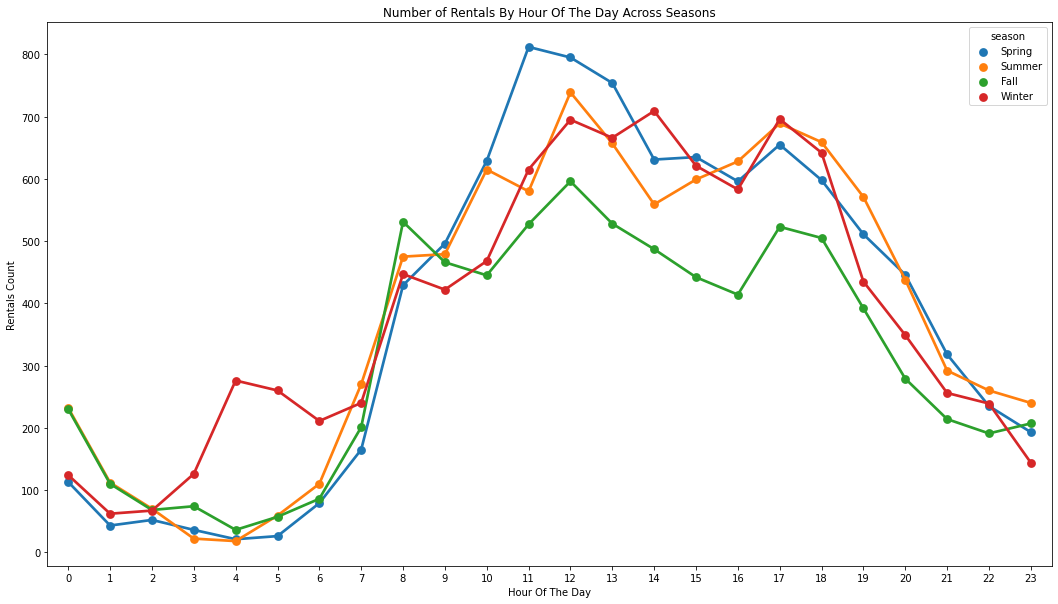

In [88]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_data.groupby(['season', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=season_freq["rental_hour"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Seasons")
plt.show()

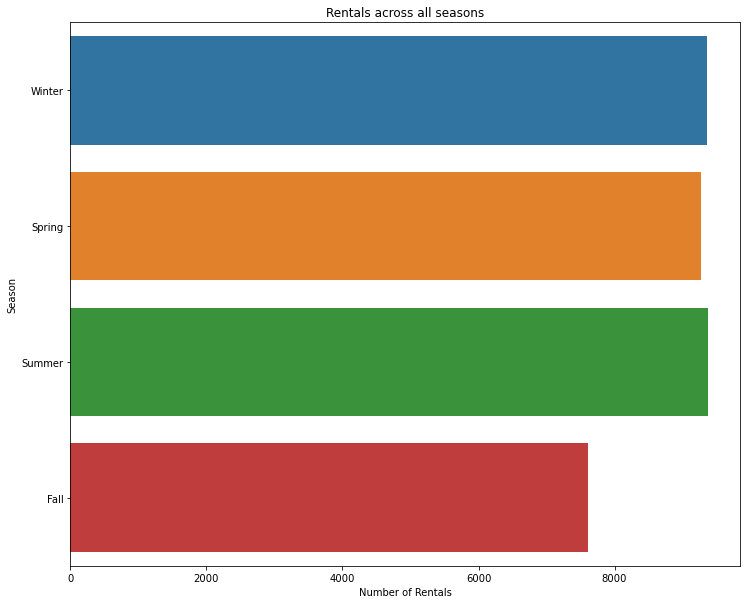

In [89]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=season_freq.groupby('season')['count'].sum().reset_index(), x='count', y='season', order=['Winter','Spring','Summer','Fall'], ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Season', title='Rentals across all seasons')
plt.show()

### Rentals by Days of the Week

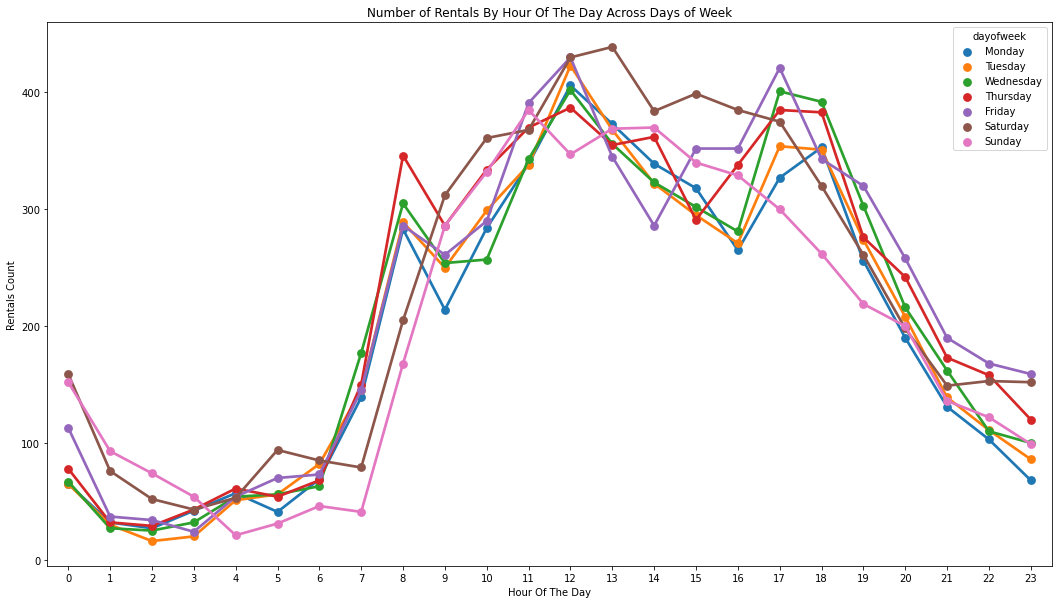

In [90]:
day_of_week_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
day_of_week = hourly_data.groupby(['dayofweek', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=day_of_week["rental_hour"], y=day_of_week["count"], hue=day_of_week["dayofweek"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Days of Week")
plt.show()

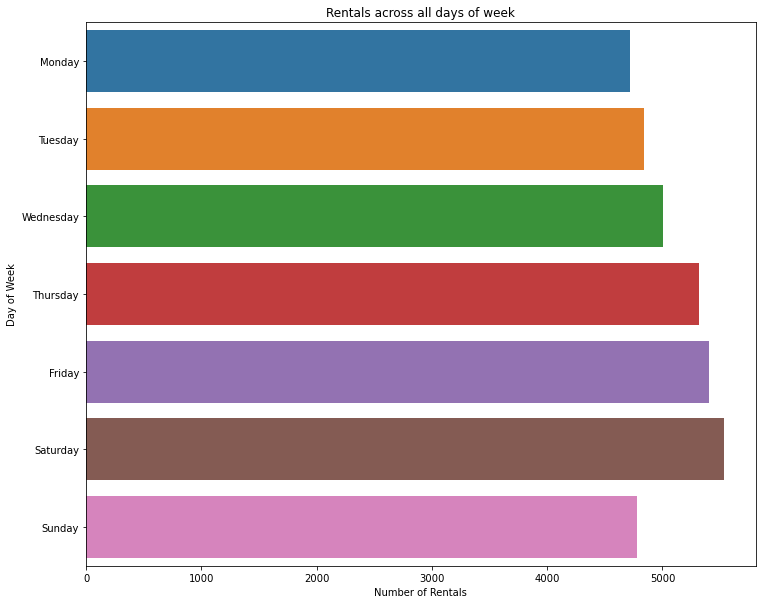

In [91]:
day_of_week = hourly_data.groupby('dayofweek')['count'].agg('sum').reset_index(name='count')
day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=day_of_week, x='count', y='dayofweek', ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Day of Week', title='Rentals across all days of week')
plt.show()

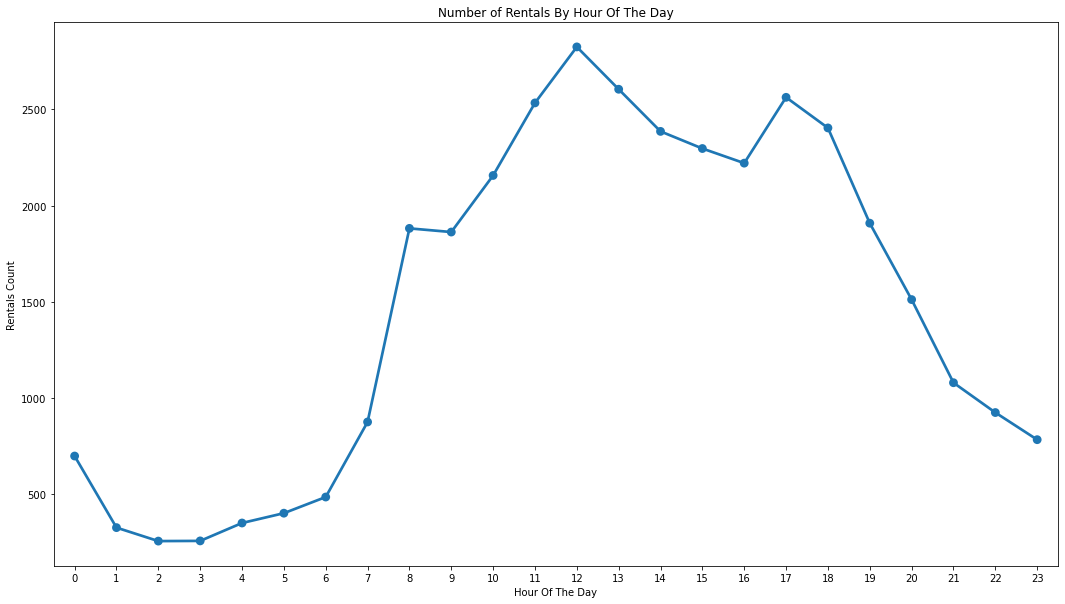

In [92]:
hourly_count = hourly_data.groupby('rental_hour')['count'].agg('sum').reset_index(name='count')

fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=hourly_count['rental_hour'], y=hourly_count['count'], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day")
plt.show()

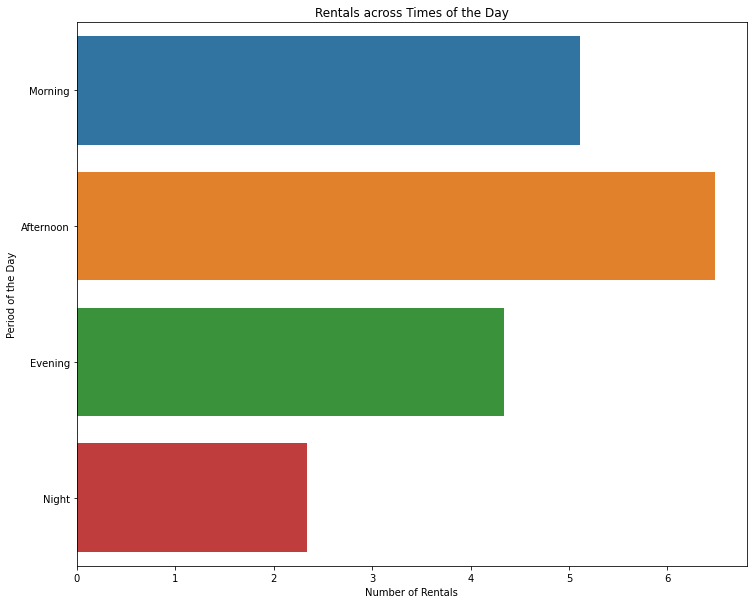

In [93]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=hourly_data, x='count', y='timesofday', ci=None, order=['Morning','Afternoon','Evening','Night'])
ax.set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')
plt.show()

In [94]:
hourly_data.groupby('timesofday').size()

timesofday
Afternoon    2299
Evening      1804
Morning      1822
Night        1522
dtype: int64

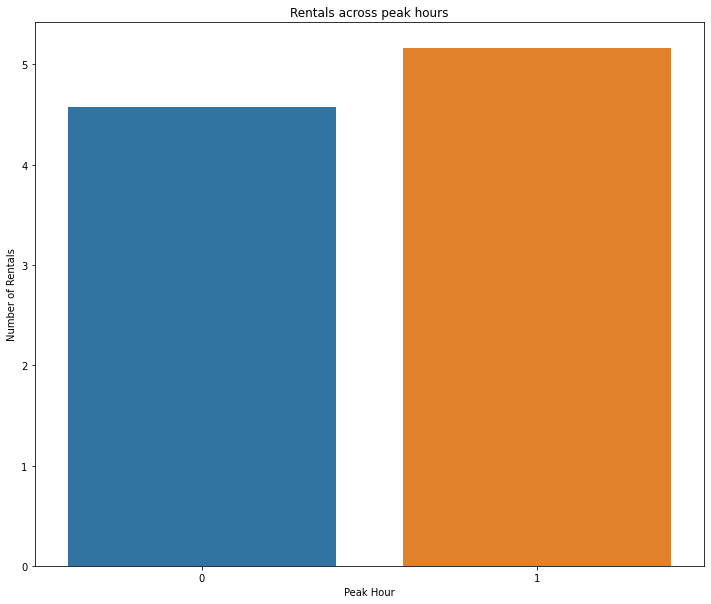

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=hourly_data, x='peak', y='count', ci=None)
ax.set(xlabel='Peak Hour', ylabel='Number of Rentals', title='Rentals across peak hours')
plt.show()

In [96]:
from scipy import stats
a = hourly_data['peak']
b = hourly_data['count']

stats.pointbiserialr(a,b)


PointbiserialrResult(correlation=0.08115289336497804, pvalue=2.323217340893084e-12)

In [97]:
np.corrcoef(a,b)

array([[1.        , 0.08115289],
       [0.08115289, 1.        ]])

## Battery distribution

In [98]:
battery_dist = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    battery_dist['battery_status'] = pd.cut(battery_dist['start_battery'], bins=bins, labels=labels, right=False)

    s = battery_dist.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    return pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}, labels)

In [99]:
group_battery_status(battery_dist)

,counts,per,per100
< 30%,3040,0.086731,8.7%
30% - 50%,6186,0.176486,17.6%
50% - 80%,15077,0.430145,43.0%
> 80%,10748,0.306639,30.7%


<AxesSubplot:xlabel='start_battery', ylabel='Count'>

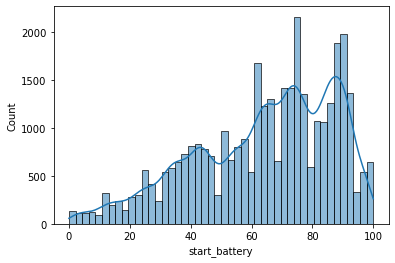

In [100]:
sns.histplot(data=rentals, x='start_battery', kde=True)

In [101]:
all_data['duration'].mean()

974.2652058131958

## BoxPlot analysis

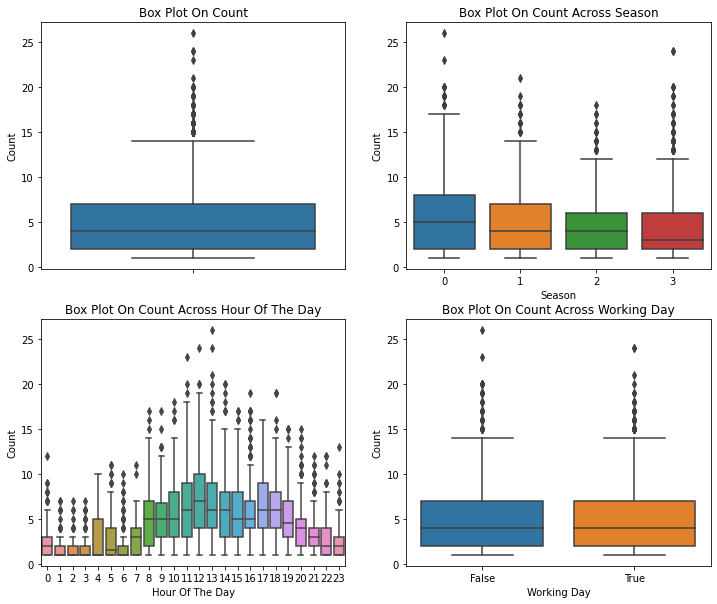

In [102]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hourly_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_data,y="count",x="rental_hour",orient="v",ax=axes[1][0])
sns.boxplot(data=hourly_data,y="count",x="working_day",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()

In [103]:
hourly_data[hourly_data['count'] > 20]

,rental_date,rental_day,rental_year,rental_hour,holiday,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
769,2021-03-17,17,2021,13,False,2,True,3,0,Afternoon,0.0,11.4,66,11,24
806,2021-03-19,19,2021,12,False,4,True,3,0,Afternoon,0.0,10.2,80,4,24
1077,2021-04-03,3,2021,11,False,5,False,0,0,Morning,0.0,10.1,65,7,23
1331,2021-04-17,17,2021,13,False,5,False,0,0,Afternoon,0.0,11.3,56,14,26
2570,2021-06-22,22,2021,13,False,1,True,1,0,Afternoon,0.0,16.9,44,7,21


## Correlation Matrix

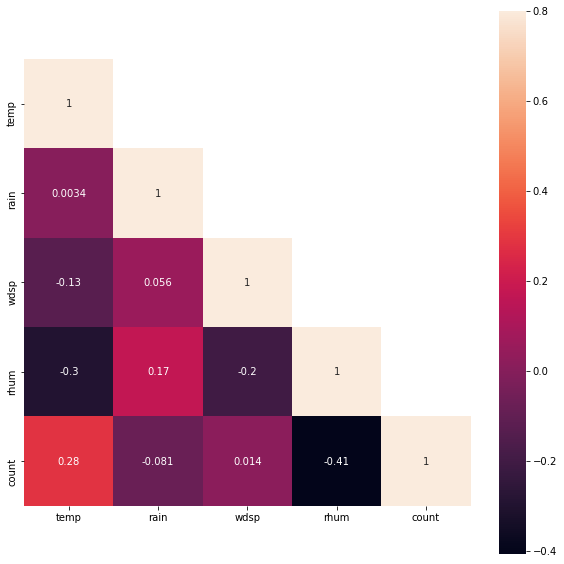

In [104]:
corrMatt = hourly_data[['temp','rain','wdsp','rhum','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

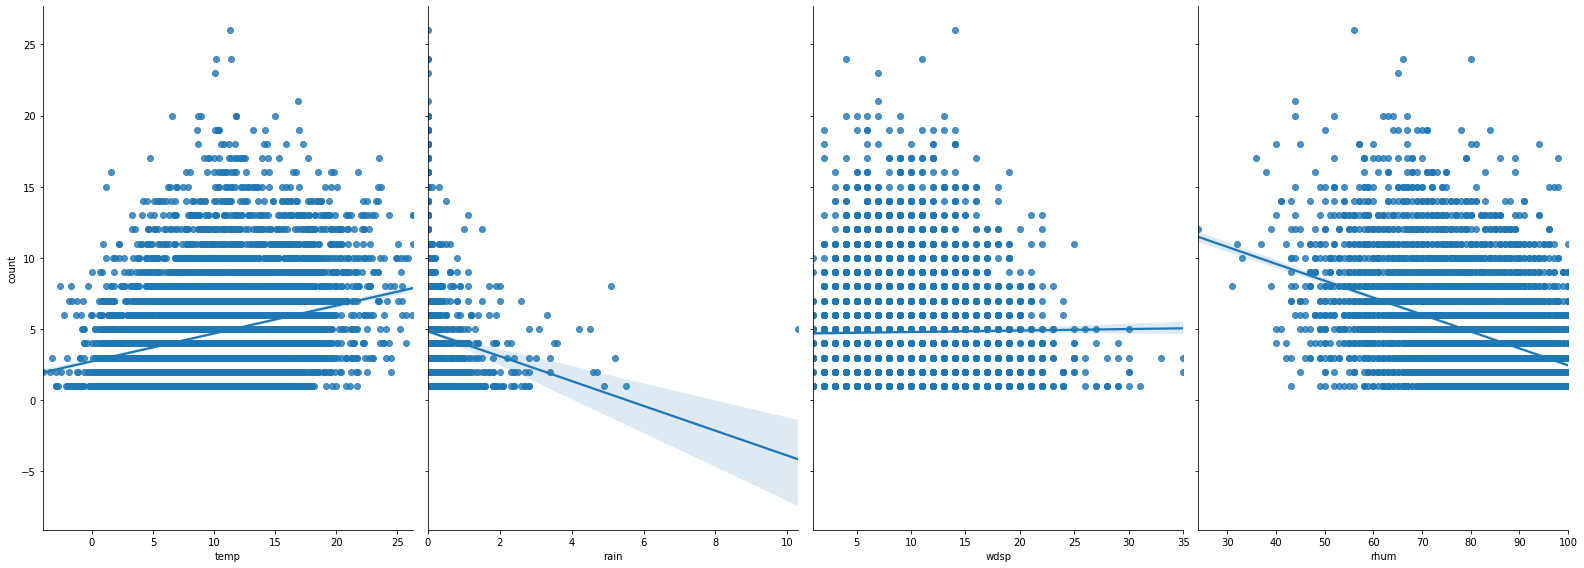

In [105]:
sns.pairplot(hourly_data, x_vars=['temp','rain','wdsp','rhum'], y_vars='count', height=8, aspect=0.7, kind="reg", palette='Set1')
plt.show()

## Distribution of numerical features

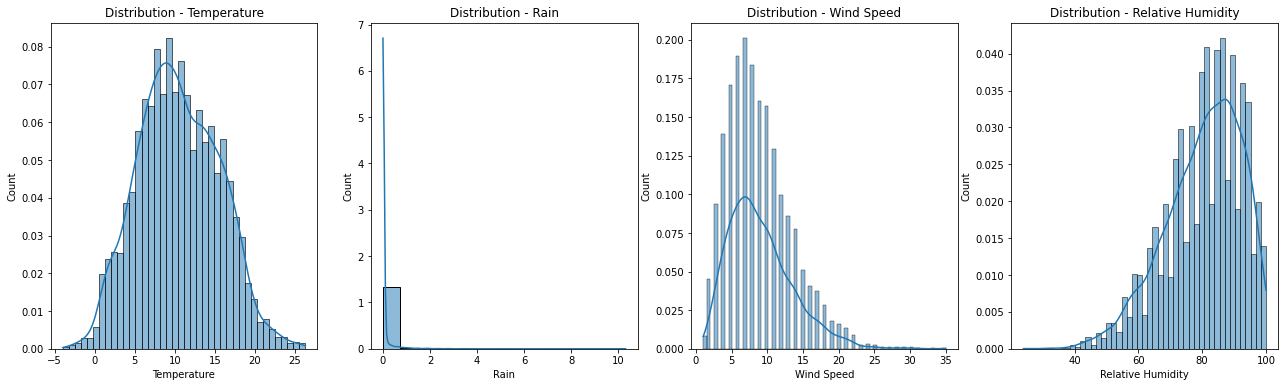

In [106]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])

sns.histplot(hourly_data['temp'],ax=ax0, stat='density', kde=True)
sns.histplot(hourly_data['rain'],ax=ax1, stat='density', kde=True)
sns.histplot(hourly_data['wdsp'],ax=ax2, stat='density', kde=True)
sns.histplot(hourly_data['rhum'],ax=ax3, stat='density', kde=True)

ax0.set(xlabel='Temperature',ylabel='Count',title="Distribution - Temperature")
ax1.set(xlabel='Rain', ylabel='Count',title="Distribution - Rain")
ax2.set(xlabel='Wind Speed', ylabel='Count',title="Distribution - Wind Speed")
ax3.set(xlabel='Relative Humidity', ylabel='Count',title="Distribution - Relative Humidity")

plt.show()

In [107]:
from sklearn.decomposition import PCA

In [108]:
hourly_data.head()

,rental_date,rental_day,rental_year,rental_hour,holiday,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
0,2021-02-01,1,2021,6,False,0,True,3,1,Night,0.0,3.4,98,3,1
1,2021-02-01,1,2021,8,False,0,True,3,1,Morning,0.0,3.5,93,4,2
2,2021-02-01,1,2021,9,False,0,True,3,1,Morning,0.0,2.6,93,2,4
3,2021-02-01,1,2021,10,False,0,True,3,1,Morning,0.0,4.1,97,4,3
4,2021-02-01,1,2021,11,False,0,True,3,0,Morning,0.0,5.2,86,6,12


<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini